# EXTRACTING TEXT FROM A SCREENSHOT 

and potentially feeding it to a search engine or (online) dictionary

### References:

- <a href="https://tesseract-ocr.github.io/tessdoc/Home.html">Tesseract User Manual</a>
- [Longdo Thai Dictionary](https://dict.longdo.com/search/)

In [4]:
# pip install pytesseract

from PIL import Image
from PIL import ImageGrab
import pytesseract
import requests as rq
from bs4 import BeautifulSoup as bs
from IPython.display import display
from IPython.display import HTML
import threading
from datetime import datetime as dt

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
print('>>> Likely imported.')

>>> Likely imported.


In [81]:
class ClipImg2Text:
    config_codes = """  0    Orientation and script detection (OSD) only.
      1    Automatic page segmentation with OSD.
      2    Automatic page segmentation, but no OSD, or OCR.
      3    Fully automatic page segmentation, but no OSD. (Default)
      4    Assume a single column of text of variable sizes.
      5    Assume a single uniform block of vertically aligned text.
      6    Assume a single uniform block of text.
      7    Treat the image as a single text line.
      8    Treat the image as a single word.
      9    Treat the image as a single word in a circle.
     10    Treat the image as a single character.
     11    Sparse text. Find as much text as possible in no particular order.
     12    Sparse text with OSD.
     13    Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific."""
    config_dict = {int(entry[0]): entry[1] for entry in [entry.strip().split('    ') for entry in config_codes.split('\n')]}
    corpus_path = r'F:\User\Learn\ไทยศึกษา\Lingvistics\lexitron_thai.txt'

    
    def __init__(self):
        self.im = None
        self.out_texts = {}
        self.validated_words = {}
        
    def grab(self):
        self.bim = None
        im = ImageGrab.grabclipboard()
        if im:
            self.im = im  # .convert("L")
        else:
            print('Looks like there was no image to grab. Please check the clipboard contents!')
        
    def binarize(self, skew=1):
        im = self.im.copy().convert("L")
        lightness = len(im.getdata()) / sum(im.getdata())
        threshold = sum(im.getextrema())/2 * skew
        xs, ys = im.size
        for x in range(xs):
            for y in range(ys):
                if im.getpixel((x, y)) > threshold:
                    px = 255 # if lightness > 0.25 else 0
                else:
                    px = 0 # if lightness > 0.25 else 255
                im.putpixel((x, y), px)
        return im
    
    def fan_binarize(self):
        self.bims = {}
        for skew in range(50,150,5):
            bim = self.binarize(skew/100)
            bim.save(f'bims/{skew}.png')
            self.bims[skew] = bim
    
    def recognize_original(self, lang='tha', config='--psm 7'):
        return pytesseract.image_to_string(self.im, config=config, lang=lang).strip() 
    
    def fan_recognize_original(self, lang='tha'):
        for code in list(self.config_dict.keys())[3:]:
            try:
                self.out_texts[code] = self.recognize_original(lang = lang, config=f'--psm {code}')
            except Exception as e:
                # texts[code] = e.__str__()
                continue
    
    def recognize_bin(self, skew=1, lang='tha', config='--psm 7'):
        bim = self.binarize(skew)
        return pytesseract.image_to_string(bim, config=config, lang=lang).strip()
                
    def fan_recognize(self, lang, psm):
        """For given psm value, recognizing original image and binarized in a range of threshold skews
        from self.bims, which will have to be already prepared"""
        self.out_texts[psm] = self.recognize_original(lang=lang, config=f'--psm {psm}')
        for skew, image in self.bims.items():
            key = psm * 1000 + skew
            self.out_texts[key] = pytesseract.image_to_string(image, lang=lang, config=f'--psm {psm}').strip()
        print(len(self.out_texts))
        
    def threads_recognize(self, lang, kind=None):
        """Recognizing the image, both original and binarized, in a range of psm values as per :kind:,
        appying a range of threshold skews as defined in `fan_recognize` for each psm value"""
        self.fan_binarize()
        lang = lang
        self.out_texts.clear()
        psms = list(self.config_dict.keys())[3:]
        psms.insert(0, 1)
        if kind == 'block':
            psms = (1, 3, 4, 6, 11, 12, 13)
        if kind == 'line':
            psms = (1, 3, 4, 6, 7, 11, 12, 13)
        threads = [threading.Thread(target=self.fan_recognize, args=(lang, psm), name=f't_{psm}') for psm in psms]
        for thread in threads:
            thread.start()
        for thread in threads:
            thread.join()
    
    def validate_words(self):
        self.validated_words.clear()
        with open(self.corpus_path, encoding='utf-8') as corpus:
            words = [line.strip() for line in corpus.readlines()]
            for key, word in self.out_texts.items():
                if word in words:
                    self.validated_words[key] = word
        freqs = {}
        for word in self.validated_words.values():
            freqs[word] = freqs.get(word, 0) + 1
        total = sum(freqs.values())
        for key, val in freqs.items():
            freqs[key] = round(val/total, 2)
        return dict(sorted(freqs.items(), key=lambda item: item[1], reverse=True))

In [3]:
def lookup(text):
    dic_url = 'https://dict.longdo.com/search/'
    response = rq.get(dic_url + text, timeout=180)
    if not response.status_code == 200:
        print("Couldn't fetch.")
        return
    response.encoding = 'utf-8'
    soup = bs(response.text)
    headers = soup.find_all('td',  attrs={'class': 'search-table-header'})
    tables = soup.find_all('table', attrs={'class': 'search-result-table'})
    html='''<style>table {width: 60%;} </style>'''
    for header, table in zip(headers, tables):
        contents = header.text
        if not ('Subtitles' in contents or 'German-Thai:' in contents or 'French-Thai:' in contents):
            html += f'<h5>{header.text}<h5>'
            html += str(table).replace("black", "white")
    display(HTML(html))

In [82]:
ex = ClipImg2Text()

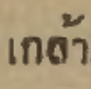

In [83]:
ex.grab()
ex.im

In [84]:
start = dt.now()
ex.threads_recognize('tha')
print(f'Done in {dt.now() - start}')

198
200
203
206
209
214
217
218
221
222
251
252
Done in 0:00:03.086000


In [30]:
for key in ex.out_texts.keys():
    text = ex.out_texts[key]
    if len(text) > 22 and '' in text:
        print(str(key) + ': \n')
        print(text)
        print('\n' * 3)

7: 

private static StringBuilder builder = new StringBuilder()|;




7050: 

private static StringBuilder builder = new StringBuilder tH};




7055: 

private static StringBuilder builder = new StringBuilder(}|;




7060: 

Private static StringBuilder builder = new StringBuilder()|




7065: 

private static StringBuilder builder = new StringBuilder()|;




7070: 

private static StringBuilder builder = new StringBuilder()};




7075: 

private static StringBuilder builder = new StringBuilder()}




7080: 

private static StringBuilder builder = new StringBuilder()|:




7085: 

private static StringBuilder builder = new StringBuilder()|;




7090: 

private static StringBuilder builder = new StringBuilder()|;




7095: 

private static StringBuilder puiider = rew StringBuilder()|;




7100: 

pois sc is StringBuilder =1 StringBuilder ()|,




7105: 

StringBuilder = StringBuilder{)|




7110: 

StringBuilder = StringBuilder()|




7115: 

StringBuilder = StringBuilder]




7120: 

S

In [87]:
text = ex.recognize_original(config='--psm 1')
text

'ม\nเกลา'

In [57]:
ex.fan_recognize_original()
# ex.fan_recognize_bin()

In [86]:
suggestions = ex.validate_words()
suggestions

{'เกล้า': 0.29,
 'เกศา': 0.23,
 'เกลา': 0.14,
 'เกล': 0.14,
 'แง': 0.09,
 'เจอ': 0.07,
 'เอ้': 0.02,
 'เจ': 0.02}

In [157]:
keys = list(suggestions.keys())
if keys:
    top = keys[0]
    print(f'The best guess is "{top}" rated {suggestions[top]} out of {len(ex.validated_words)}')
    print(f'Others:')
    for i in range(1, len(suggestions)):
        print(f'{i} - {keys[i]} ({suggestions[keys[i]]})', end='\t')
    word = input('Enter to proceed with top-rated suggestion or number for other or any different word:')
    if not word:
        lookup(top)
    else:
        try:
            lookup(keys[int(word)])
        except:
            lookup(word)

The best guess is "เกล้า" rated 0.3 out of 53
Others:
1 - เกศา (0.23)	2 - เกล (0.15)	3 - เกลา (0.11)	4 - แง (0.09)	5 - เจอ (0.08)	6 - เอ้ (0.02)	7 - เจ (0.02)	

Enter to proceed with top-rated suggestion or number for other or word: 


เกล้า,"(v) wear hair in a bun or coil, See also: gather hair up, dress a tuft of hair, tie up hair in a bun, Syn. รวบ, มุ่น, Ant. ปล่อย, Example: ทางด้านวัฒนธรรม ชาวผู้ไทสวมเครื่องประดับ สร้อยข้อมือ ข้อเท้าด้วยโลหะเงิน เกล้าผมมวยสูงตั้งตรง มัดมวยด้วยผ้าแถบผืนเล็กๆ, Thai Definition: มุ่นผมให้เรียบร้อย"
เกล้า,"(n) head, See also: skull, Syn. หัว, กระหม่อม, เศียร, ศีรษะ, Example: การลงภาพบุคคลในสถาบันที่สาธารณชนเคารพสักการะและนับถือไว้เหนือเกล้าเหนือหัวนั้นควรระมัดระวังความเสื่อมเสียหายให้มาก, Count Unit: หัว"
เกล้า,(เกฺล้า) น. หัว (ใช้เฉพาะในโวหารแสดงความเคารพอย่างสูง) เช่น มารดาบังเกิดเกล้า.
เกล้า,(เกฺล้า) ก. มุ่นผมให้เรียบร้อย เช่น เกล้าจุก เกล้ามวย.
เกล้า,[klāo] (n) EN: crown of the head ; head ; skull
เกล้า,[klāo] (v) EN: wear hair in a bun or coil ; gather hair up ; dress a tuft of hair ; tie up hair in a bun
bloodcurdling,"adj. ขนพอง, สยองเกล้า, น่ากลัวมาก"
coronet,"(คอ'ระนิท) n. มงกุฎเล็ก, รัดเกล้าของสตรี"
diadem,"(ได'อะเดม) n., vt. (ใส่) มงกุฎ, รัดเกล้า, พระราชอำนาจ, พระฐานันดรศักดิ์., Syn. crown"
bloodcurdling,"(adj) น่ากลัวมาก, น่าขนพองสยองเกล้า"
circlet,"(n) วงแหวน, รัดเกล้า"


In [142]:
lookup('ฮํา')

In [99]:
for code in ex.config_dict.keys():
    print(code, end=': ')
    for key in ex.out_texts.keys():
        if str(key).startswith(str(code)):
            print(ex.out_texts[key].replace('\n', ''), end=', ')
    print()

0: 
1: เกสา, เกต้า, เกสา, 081, , แง, แง้ง, , เจอ, มเกลา, เกสา, เกตา, เกด1, เกด1, เกดา, เกศา, เกต้า, เก ตํา, เกศา, เกต้า, เกศา, เกศา, , เกล้า, เกตลํา, |-ไ, เกศา, เกล้า, เกลํา, เกตลํา, เกต้า, เกลํา, เกลํา, เกส้า, เกสลํา, เกลํา, เกต้ว, ซี2, เกลํา, 1ซี2, เกสลํา, เกต, เกส, เกลํา, เกต, เกล, เกส, เกต้า, เกล, เกล, เกด1, เกต้า, เกด1, เกฮา, เกล, เกล้า, เกฮา, เกฮา, เกล้า, เกลว, เกล้า, เกฮา, เกล่ว, เกศา, เกล้า, เกศา, เกลว, เกลว, เกล้า, 9%#เกอว, เกล่ว, เกลว, เกอ้า, เก ตํา, เกลา, เกศา, เกตา, เกตลํา, มเกลา, เกลํา, ม7เกลา, เกลํา, มเกลา, เกสลํา, มดเกลา, เกลํา, เกลา, เกส, อลเกอา, เกล, มเกลา, เกล, ม/เกลา, เกฮา, ม/เกลา, เกฮา, ม/เกลา, เกลว, นดเกลา, เกล่ว, */เกลา, เกลว, ฆเกลว, 9%#เกอว, , 
2: 
3: มเกลา, , ซี2, เกด1, เกศา, เกลา, เกตา, มเกลา, ม7เกลา, มเกลา, มดเกลา, เกลา, อลเกอา, มเกลา, ม/เกลา, ม/เกลา, ม/เกลา, นดเกลา, */เกลา, ฆเกลว, , 
4: มเกลา, แง, เจอ, เกด1, เกศา, เกลา, เกตา, มเกลา, ม7เกลา, มเกลา, มดเกลา, เกลา, อลเกอา, มเกลา, ม/เกลา, ม/เกลา, ม/เกลา, นดเกลา, */เกลา, ฆเกลว, , 
5: *๑๐6เร, เซซี, ๒๕7ลอ-, ๐=ว, ๒==,

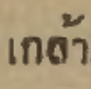

1: มเกลา, 3: มเกลา, 4: มเกลา, 5: *๑๐6เร, 6: มเกลา, 7: เกสา, 8: เกต้า, 9: เมื, 10: เกสา, 11: เกสา, 12: เกสา, 13: เกต้า, 
0.5


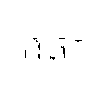

1: , 3: , 4: แง, 5: เซซี, 6: แง, 7: แง, 8: , 9: แง, 10: แง, 11: 081, 12: |-ไ, 13: , 

0.55


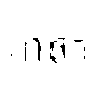

1: ซี2, 3: ซี2, 4: เจอ, 5: ๒๕7ลอ-, 6: เจอ, 7: เจอ, 8: , 9: , 10: เจอ, 11: แง้ง, 12: 1ซี2, 13: , 

0.6


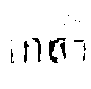

1: เกด1, 3: เกด1, 4: เกด1, 5: ๐=ว, 6: เกด1, 7: เกด1, 8: เกตา, 9: เกตา, 10: เกด1, 11: เกด1, 12: เกด1, 13: เกตา, 

0.65


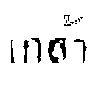

1: เกศา, 3: เกศา, 4: เกศา, 5: ๒==, 6: เกศา, 7: เกศา, 8: เกดา, 9: เกดา, 10: เกศา, 11: เกศา, 12: เกศา, 13: เกดา, 

0.7


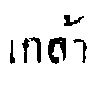

1: เกลา, 3: เกลา, 4: เกลา, 5: 3564เซซี, 6: เกลา, 7: เก ตํา, 8: เกต้า, 9: เกต้า, 10: เกศา, 11: เก ตํา, 12: เก ตํา, 13: เกต้า, 

0.75


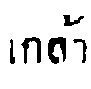

1: เกตา, 3: เกตา, 4: เกตา, 5: เณ๐เซอ=, 6: เกตา, 7: เกศา, 8: เกต้า, 9: เกต้า, 10: เกศา, 11: เกศา, 12: เกศา, 13: เกต้า, 

0.8


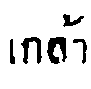

1: มเกลา, 3: มเกลา, 4: มเกลา, 5: 5๐6๐, 6: มเกลา, 7: เกตลํา, 8: เกล้า, 9: เกล้า, 10: เกตลํา, 11: เกตลํา, 12: เกตลํา, 13: เกล้า, 

0.85


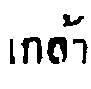

1: ม7เกลา, 3: ม7เกลา, 4: ม7เกลา, 5: %๒๑เซซี๐=, 6: ม7เกลา, 7: เกลํา, 8: เกล้า, 9: เกล้า, 10: เกลํา, 11: เกลํา, 12: เกลํา, 13: เกล้า, 

0.9


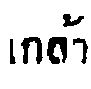

1: มเกลา, 3: มเกลา, 4: มเกลา, 5: ๐6=๐=, 6: มเกลา, 7: เกลํา, 8: เกต้า, 9: เกต้า, 10: เกลํา, 11: เกลํา, 12: เกลํา, 13: เกต้า, 

0.95


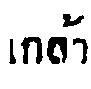

1: มดเกลา, 3: มดเกลา, 4: มดเกลา, 5: 5๒๐เซอร๐, 6: มดเกลา, 7: เกสลํา, 8: เกส้า, 9: เกส้า, 10: เกสลํา, 11: เกสลํา, 12: เกสลํา, 13: เกส้า, 

1.0


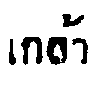

1: เกลา, 3: เกลา, 4: เกลา, 5: ฉิ6๒๐เ=<รี, 6: เกลา, 7: เกลํา, 8: เกต้ว, 9: เชื, 10: เกลํา, 11: เกลํา, 12: เกลํา, 13: เกต้ว, 

1.05


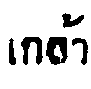

1: อลเกอา, 3: อลเกอา, 4: อลเกอา, 5: 5๑6๐, 6: อลเกอา, 7: เกส, 8: เกต, 9: เม, 10: เกส, 11: เกส, 12: เกส, 13: เกต, 

1.1


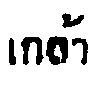

1: มเกลา, 3: มเกลา, 4: มเกลา, 5: *๑เซเร, 6: มเกลา, 7: เกล, 8: เกต, 9: 0, 10: เกล, 11: เกล, 12: เกล, 13: เกต, 

1.15


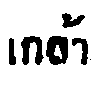

1: ม/เกลา, 3: ม/เกลา, 4: ม/เกลา, 5: *๑๕=, 6: ม/เกลา, 7: เกล, 8: เกต้า, 9: เอ้, 10: เกล, 11: เกล, 12: เกล, 13: เกต้า, 

1.2


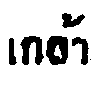

1: ม/เกลา, 3: ม/เกลา, 4: ม/เกลา, 5: *๑วร๐, 6: ม/เกลา, 7: เกฮา, 8: เกต้า, 9: เด, 10: เกฮา, 11: เกฮา, 12: เกฮา, 13: เกต้า, 

1.25


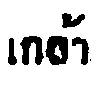

1: ม/เกลา, 3: ม/เกลา, 4: ม/เกลา, 5: *๑เร=, 6: ม/เกลา, 7: เกฮา, 8: เกล้า, 9: เจ, 10: เกฮา, 11: เกฮา, 12: เกฮา, 13: เกล้า, 

1.3


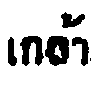

1: นดเกลา, 3: นดเกลา, 4: นดเกลา, 5: *๑เร๓=, 6: นดเกลา, 7: เกลว, 8: เกล้า, 9: ง, 10: เกลว, 11: เกลว, 12: เกลว, 13: เกล้า, 

1.35


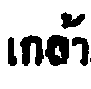

1: */เกลา, 3: */เกลา, 4: */เกลา, 5: *6วร๐=, 6: */เกลา, 7: เกล่ว, 8: เกล้า, 9: เกล่ว, 10: เกล่ว, 11: เกล่ว, 12: เกล่ว, 13: เกล้า, 

1.4


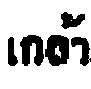

1: ฆเกลว, 3: ฆเกลว, 4: ฆเกลว, 5: *6ววณา, 6: ฆเกลว, 7: เกลว, 8: เกล้า, 9: เกลว, 10: เกลว, 11: เกลว, 12: เกลว, 13: เกล้า, 

1.45


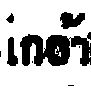

1: , 3: , 4: , 5: 2, 6: ง จข,เกอว, 7: เกอ้า, 8: เกล้า, 9: เกอ้า, 10: เกอ้า, 11: 9%#เกอว, 12: 9%#เกอว, 13: เกล้า, 


In [126]:
display(ex.im)
for key, text in sorted(ex.out_texts.items(), key=lambda item: item[0]):
    if key <= 13:
        print(f'{key}:', text.replace('\n', ''), end=', ')

for skew, image in ex.bims.items():
    print(f'\n{skew/100}')
    display(image)
    for key, text in sorted(ex.out_texts.items(), key=lambda item: item[0]):
        if str(key).endswith(str(skew)):
            print(f'{key//1000}:', text.replace('\n', ''), end=', ')
    print()